<!-- In this notebook we analyze the responses from both human participants and models to the question how typical is this text from the concept X -->

**Author**: Gaël Le Mens, Universitat Pompeu Fabra

*Updated by Alexander Hoyle 2025-09-08 to filter to high-agreement expert data*

**Date**: 2024/08/16

**Description:** Loads the position scores produced by  LLMS and compares them to the positions produced by experts and crowdsourced estimates in Benoît et al (ASPR, 2016).

Select the policy dimension and whether to analyze the case in which the policy dimension is included in the prompt by commenting out the appropriate lines in section '1. Analysis mode'


In [1]:
import pandas as pd
import numpy as np

# Paths for where to load the data


In [2]:
data_rel_path = "./british-party-manifestos/"
data_from_Benoit_et_al_2016_rel_path = data_rel_path + "data_from_Benoit_et_al_2016/" 

data_analysis_path_rel_path = data_rel_path + "data_analysis/"

# Data loading

## parameters

In [3]:
INFO_PATH_PARTY_MANIFESTO_UK_SENTENCES = data_from_Benoit_et_al_2016_rel_path+"master.sentences.csv"

human_data_long_path = data_from_Benoit_et_al_2016_rel_path + "coding_all_long_2014-03-14.csv"
human_data_wide_path = data_from_Benoit_et_al_2016_rel_path + "coding_all_wide_2014-03-14.csv"

info = pd.read_csv(INFO_PATH_PARTY_MANIFESTO_UK_SENTENCES, dtype={"sentenceid": str}, index_col=0)
info.rename(columns={"sentenceid": "id", 'manifestoid': 'textid'}, inplace=True)

display(len(info))
display(info.columns)

18263

Index(['id', 'textid', 'party', 'year', 'sentence_text_old', 'sentence_nchars',
       'sentence_nwords', 'sentence_mean_word_length', 'total_syllables',
       'n_complex_words', 'nouns', 'verbs', 'adjs', 'advs', 'propnouns',
       'truncated', 'sentence_text', 'policy_area_gold', 'econ_scale_gold',
       'soc_scale_gold', 'X_gold', 'pre_sentence', 'post_sentence',
       'policy_area_gold_reason'],
      dtype='object')

## read data

In [4]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

human_data_long = pd.read_csv(human_data_long_path, dtype = {"sentenceid": str, "codingid": str, "coderid": str, "manifestoid": str}, low_memory=False)
human_data_long.rename(columns={"sentenceid": "id", 'manifestoid': 'objectid'}, inplace=True)
display(len(human_data_long))
#human_data_long = human_data_long.loc[(human_data_long['source']==SOURCE),:]
display(len(human_data_long))
# display(len(human_data_long))
human_data_long['pos_human'] = human_data_long['code']
human_data_long['policy_area'] = human_data_long['scale']
human_data_long[['nb_responses_human']]=1
human_data_long = human_data_long.merge(info[['id','sentence_text']], on = 'id', how = 'right')
display(len(human_data_long))
display(human_data_long['id'].nunique())
display(human_data_long['policy_area'].value_counts())
# if MODE == "UK_Economic":
#     human_data_long = human_data_long[human_data_long['policy_area']=="Economic"]
# elif MODE == "UK_Social":
#     human_data_long = human_data_long[human_data_long['policy_area']=="Social"]
display(human_data_long['policy_area'].value_counts())


346793

346793

344839

18263

None        164847
Economic    117030
Social       62962
Name: policy_area, dtype: int64

None        164847
Economic    117030
Social       62962
Name: policy_area, dtype: int64

In [5]:
# all ratings
human_pos_ratings = human_data_long[['id','source','policy_area','coderid','pos_human','party','year','sentence_text']].sort_index().dropna(subset=['pos_human'])
display(human_pos_ratings)

,id,source,policy_area,coderid,pos_human,party,year,sentence_text
30,10000011,Experts,Social,Ken,1.0,Conservatives,1987,We have discovered a new strength and a new pride.
60,10000021,Experts,Economic,Ken,1.0,Conservatives,1987,We have fostered a new spirit of enterprise.
61,10000021,Experts,Economic,Mik,1.0,Conservatives,1987,We have fostered a new spirit of enterprise.
63,10000021,Experts,Economic,Pablo,1.0,Conservatives,1987,We have fostered a new spirit of enterprise.
64,10000021,Experts,Economic,Pablo,1.0,Conservatives,1987,We have fostered a new spirit of enterprise.
...,...,...,...,...,...,...,...,...
344805,1180013451,Crowd,Social,1.40e+07,2.0,Labour,2010,"Use our international reach to build security and stability - combating terrorism and extremism, curbing proliferation, preventing and resolving conflict, and tackling climate change."
344813,1180013461,Crowd,Economic,1.10e+07,-1.0,Labour,2010,"Lead the agenda for an outward-facing European Union that delivers jobs, prosperity and global influence."
344819,1180013471,Experts,Economic,Pablo,-1.0,Labour,2010,"Re-energise the drive to achieve the Millennium Development Goals, supporting sustainable growth and combating poverty."
344826,1180013471,Crowd,Economic,1.13e+07,0.0,Labour,2010,"Re-energise the drive to achieve the Millennium Development Goals, supporting sustainable growth and combating poverty."


In [6]:
human_pos_ratings["label"] = human_pos_ratings["pos_human"] + 3 # will be a 1 to 5 scale
human_pos_ratings = human_pos_ratings.loc[human_pos_ratings["source"].isin(["Experts", "Crowd"])]
human_ratings_grouped = (
    human_pos_ratings.groupby(["id", "source", "policy_area", "party", "year", "sentence_text"], as_index=False)
    .agg(
        n_annotators=("label", "count"),
        label_mean=("label", "mean"),
        label_std=("label", "std"),
    )
)
human_ratings_grouped["label_ordinal"] = human_ratings_grouped["label_mean"].round().astype(int)

In [7]:
human_ratings_grouped.to_json("british-party-manifestos/processed/manifestos_grouped.jsonl", orient="records", lines=True)

### Filter down to high-agreement expert cases

In [8]:
MIN_ANNOTATORS_PER_ITEM = 3
MAX_STD_PER_ITEM = 0.5

# filter to Experts and items within the thresholds
high_agreement_expert_ratings = human_ratings_grouped.loc[
    (human_ratings_grouped["n_annotators"] >= MIN_ANNOTATORS_PER_ITEM)
    & (human_ratings_grouped["label_std"] <= MAX_STD_PER_ITEM)
    & (human_ratings_grouped["source"] == "Experts")
]

len(high_agreement_expert_ratings)

human_ratings_filtered = human_ratings_grouped.loc[
    human_ratings_grouped["id"].isin(high_agreement_expert_ratings["id"])
]

In [9]:
joint_ids = human_ratings_filtered.groupby(["id", "policy_area"], as_index=False).agg({"source": "nunique"})
joint_ids = joint_ids[joint_ids["source"] == 2]

human_ratings_filtered = human_ratings_filtered.merge(
    joint_ids[["id", "policy_area"]], on=["id", "policy_area"], how="inner"
)

In [10]:
crowd_expert_diffs = human_ratings_filtered.groupby(["id", "policy_area"]).apply(
    lambda x: np.abs(
        x[x["source"] == "Experts"]["label_mean"].values[0]
        - x[x["source"] == "Crowd"]["label_mean"].values[0]
    ),
)

<Axes: >

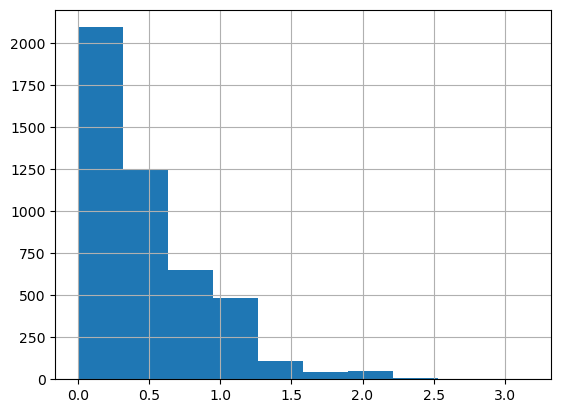

In [11]:
crowd_expert_diffs.hist(bins=10)

In [12]:
human_ratings_filtered.to_json(
    "british-party-manifestos/processed/manifestos_filtered.jsonl", orient="records", lines=True
)